# Python 3 and the geodesic algorithm

All the code for the algorithm is pulled from [this thesis](https://core.ac.uk/download/pdf/52106179.pdf)

There may be errors because of indentation screw ups.

So here is the schema from [this paper](https://arxiv.org/pdf/math/0605532.pdf)

![](./geod_algo.png)

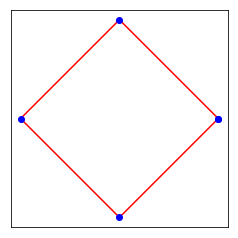

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cmath

def plt_cplx(arr, sty='r', ax=None):
    if not ax:
        plt.plot(arr.real, arr.imag,sty)
    else:
        ax.plot(arr.real, arr.imag,sty)
        
verts = [1, 1J, -1,-1J]
verts = [complex(x) for x in verts]
#verts = [(1+1J)*v for v in verts]
# add a copy of the first vertex ie path.close()
verts.append(verts[0])

#reparametrize using arclength
side_lengths = [abs(a - b ) for a,b in zip(verts, verts[1:]) ]
xs = np.zeros(len(verts))
xs[1:] = np.cumsum(side_lengths)
ZS = np.interp(np.linspace(xs[0], xs[-1], 5), xs, verts)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt_cplx(ZS);
plt_cplx(ZS, sty='bo', ax=ax);

### Most of the papers 

show the image of a Carleson grid mapped into the domain
[don't they ?](https://www.dumas.io/teaching/2013/spring/math570/handouts/mapping.pdf)

![](https://empathicdynamics.files.wordpress.com/2017/01/screenshot-from-2017-01-19-17-09-33-1.png?w=512)



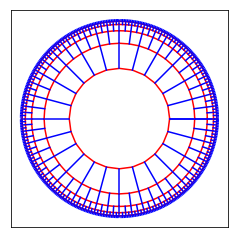

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

for k in range(1,6):
    ee = .5**k
    T = np.linspace(0,2*np.pi,12*2**k +1)
    X = np.cos(T)
    Y = np.sin(T)
    ax.plot((1 - ee) *X,(1 - ee) *Y,'r');
    for a,b in zip(X,Y):
        ax.plot([(1 - ee) *a, (1 - .5*ee) *a],
                [(1 - ee) *b, (1 - .5*ee) *b],'b');

## Let's start 

by changing the names of the functions in the thesis.

```plane2disc(1J,z)``` is a  the [Cayley transform](https://en.wikipedia.org/wiki/Cayley_transform#Complex_homography).

<img src="https://upload.wikimedia.org/wikipedia/commons/3/36/Cayley_transform_in_complex_plane.png" width="360" >

source: Wikipedia

In [8]:
# the map from the upper half plane to the unit disc

def plane2disc(a, z):
    if a.imag < 0  : 
        raise ValueError('a not in upper half space')  
    if cmath.isinf(z) : return 1
        
    return (z - a) / (z - a.conjugate())

# the inverse maps the unit disc to the upper half plane
def disc2plane(a, z):
  
    if abs(z - 1) < 1e-11:
        return cmath.inf

    return (a.conjugate()*z - a)/(z - 1)


## Carleson grid 

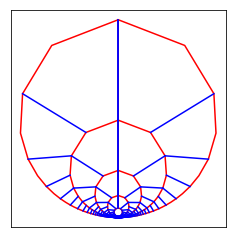

In [10]:
import itertools

def cgrid(rpts,depth):
    # return a list of lists of cplx
    rings = []
    for k in range(1,depth):
        
        T = np.linspace(0,2*np.pi,rpts*2**k/2 + 1)
        Z = np.cos(T)+  np.sin(T)*1J
        rings.append(((1  - .5**k)*Z))
   
    return rings

cc = cgrid(32,6)

center = 2J
cc = [ list(map(lambda z : disc2plane(center, z), rr))  for rr in cc]
#cc = [phidiscinv(a, Z) for Z in cc] #maybe 2.6 vs 4.2
tt = list(itertools.chain.from_iterable(cc))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)


X, Y = [z.real for z in tt], [z.imag for z in tt]
ax.plot(X,Y,'r');

for x,y in zip(cc,cc[1:]):
    for a, b in zip(x, y[::2]):
        X, Y = [z.real for z in [a,b]], [z.imag for z in [a,b]]
        ax.plot(X,Y,'b');

So there you have it, the image of the Carleson grid in 
$\mathbb{H}^2$.

Very spider's web n'est-ce pas ?

## Mapping a polygon into $\mathbb{H}^2$.

The map $\phi_1$ maps 
- $z_0$ to $\infty$
- $z_1$ to $0$
- the  line segment $z_1,z_2$ to the real axis
- the polygon to the upper half plane

In [11]:
def phi_1(z0, z1, z):
    ## rewrote with a cutoff
    if abs(z - z0) < 1e-11:  return cmath.inf
    return cmath.sqrt((z - z1)/(z - z0))

# the inverse of phi_1
def phi_1_inv(z0, z1, z):
    if cmath.isinf(z): return z0
    
    sq = z**2
    return (z1 - sq*z0)/(1 - sq)


### Let's just check 

- that they are inverses 
- that it does map to the upper half space

In [12]:
ws = [ phi_1(ZS[0],ZS[1],z) for z in ZS]
zs = [ phi_1_inv(ZS[0],ZS[1],z) for z in ws]
max([abs(a - b) for a,b in zip(ZS, zs)])

3.1401849173675503e-16

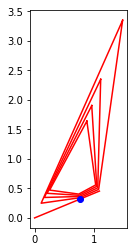

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
for k in range(5):
    tt = np.array( [ phi_1(ZS[0],ZS[1],z) 
                         for z in .9**k*ZS] )
    plt_cplx(tt, ax=ax)

plt_cplx( np.array(phi_1(ZS[0],ZS[1],ZS[2]) ) , sty='bo', ax=ax)


## The algorithm 

We have the vertices and 
we have to go round them calculating 
this $\phi_i(a, z)$.

The catch is that we have modified the vertices at each stage
so it's a kind of recursive thing.

---

Actually this is bad notation as
$$ \phi_i(a, z) = f_{z_i}(z),$$

where $z_i$ are the vertices of the domain.

---

![](unzipping.png)

---

## Degenerate case

let's start by visualizing a special case namely

- $a = i$ which means that $c=1$.

Actually if we allow rescaling of the intermediate 
polygons  <br>
so that $z_i = 1J$ we only need this map

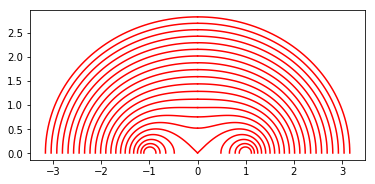

In [592]:
def f_1J(w): 
    if w == 1J : return 0
    if w == 0 : return -1
    
    S = cmath.sqrt( w**2 + 1) #again in the paper
  
    if S.real*w.real < 0: # I had to change this
        S = -S
    return S

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')


T = np.linspace(0, np.pi/2, 50)
ZZ = np.cos(T) + 1J*np.sin(T)

for r in np.linspace(.5,3,21):
    WW = np.array([f_1J(z) for z in r*ZZ])
    plt_cplx(WW, ax=ax)
    plt_cplx(-WW.conjugate(),ax=ax) #use symmetry to complete

As I say I don't really need this $f_a$
if I do some rescaling but 
- it's in the paper and the thesis

In [16]:
# the i-th map made from the basic map f_a
def f(a, z):
    # don't need cutoff going through list with a in it
    if z == a: return 0
    
    if abs(a.imag) < 1e-14:
        if cmath.isfinite(z):
            return z - a
        else:
            return z

    if cmath.isfinite(z):
        w = abs(a)**2 * z / (abs(a)**2 - a.real * z)
        
    else:
        #the limit z -> infty in the expression above
        w =  - abs(a)**2 / a.real
             
    c = abs(a)**2 / a.imag
    
    if w == 0 : return -c #degenerate case
        
    S = cmath.sqrt( w**2 + c**2) #again in the paper
  
    if S.real*w.real < 0: # I had to change this
        S = -S
    return S


In [577]:
# the (n+1)-th map mapping a half-disc in the
# upper half plane to the whole of the upper
# half plane
def half2plane(a,z):
    # $a$ should be a real number 
    if cmath.isinf(z):
        return -(1j*a)**2
    
    #this is a dumb condition
    #this is basically saying z = a**2
    if abs(1 - z/a) < 1e-14:
        return cmath.inf
    
    return (z / (1 - z/a) )**2

# the inverse of the (n+1)-th map
def plane2half(a,z):
    if cmath.isinf(z):
        return a
    
    if abs(z) < 1e-11:
        return 0

    if abs(z + (1j*a)**2) < 1e-11:
        return cmath.inf
    
    sq = cmath.sqrt(-z)  
    if sq.imag*z.imag < 0:
        sq *= -1
    return sq*a/(1j*a + sq)

In [14]:
# this needs screwing about with 
# to get an optimal distribution of pts
# or maybe I can do that at the end ??

def half2plane(a,z):
    
    if cmath.isinf(z): return a**2
    # I really don't need a cutoff here
    if z == a : return cmath.inf
    
    return -( z / (z - a) )**2

[1,
 (0.962680407045243+0.2706407838652653j),
 (-0.5932187220115932+0.8050413330102574j),
 (-1+0j)]

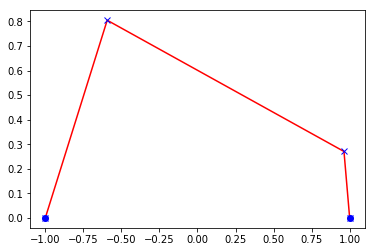

In [17]:
z_i = ZS[:-1] # remember I closed ZS up to make a path

z0, z1 = z_i[0:2]

# apply the first map
z_i = list( map(lambda x: phi_1(z0, z1, x), z_i))

# apply the i-th maps
# saves zeta_k for inverse mapping
zeta = {}
for i in range(2, len(z_i) ):
    a = z_i[i]
    zeta[i] = a
    z_i = list( map(lambda x: f(a, x), z_i) )

# map onto the whole plane
# z_i[0] < z_i[1] < ... < z_i[-1]= 0
# z_i[0] -> \inf, 0 -> 0
w_i = list( map(lambda x: half2plane(z_i[0], x), z_i))

# map to the disc 
# this was wrong as far as I can tell in the thesis
center = 1J
ww_i = list( map(lambda x: plane2disc(center, x), w_i))


## plot to see what it looks like
pts = ww_i

fig = plt.figure()
ax = fig.add_subplot(111)
plt_cplx(np.array(pts[:]), sty='r-',ax=ax)
#plt_cplx(np.array(w_i[:]), sty='bo',ax=ax)

plt_cplx(np.array(pts[:]), sty='bx',ax=ax)
plt_cplx(np.array([pts[0], pts[3]]), sty='bo',ax=ax)

pts

## Experimenting with rescaling



In [557]:
def circ2vert(a, z):  
    # the semicircle starting at 0 and passing thru a
    # to the y-axis
    # normalized so that a -> 1J
    
    if a == z: return 1J
    if a == 0: return 0

    b = abs(a)**2/a.real
    
    ff = abs(a)**2/a.imag
    
    if cmath.isinf(z):
        return - b/ff
    
    return b*z / (b - z) / ff

def f_1J(w): 
    #maybe this is numerically better ??
    if w == 1J : return 0
    if w == 0 : return -1
    
    S = cmath.sqrt( w**2 + 1) #again in the paper
    if S.real*w.real < 0: # I had to change this
        S = -S
    return S



3


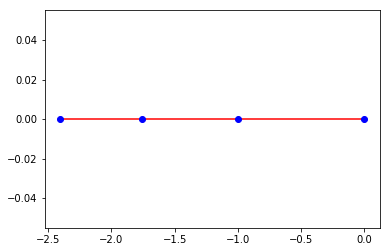

In [567]:
tt = np.copy(z_i)
for k in range(3,4):
    print(k)
    if tt[k].imag < .1**6: 
        tt -= tt[k].real
        continue
    ss = np.array( [circ2vert(tt[k], z) for z in tt[:] ])
    tt = np.array( [f_1J(z) for z in ss[:] ])
    plt_cplx(tt, sty='r-')
    plt_cplx(np.array([tt[:]]), sty='bo')
    
    

array([-2.95973103-0.j        , -2.501065  -0.j        ,
       -1.91131948-0.j        , -1.71285846-0.j        ,
       -1.65808577-0.j        , -1.6083422 -0.j        ,
       -1.48648596-0.j        , -1.36100425-0.j        ,
       -1.30218336-0.j        , -1.26200953-0.j        ,
       -1.        +0.j        ,  0.        +0.j        ,
        0.1657013 +1.27877113j, -0.68585217+1.55671133j,
       -1.670269  +1.66172407j, -2.68799567+1.20974649j])

In [39]:
# inverse map to the half plane
z_i = map(lambda x: phidiscinv(zint, x),z_i)
cgrid = map(lambda x: phidiscinv(zint,x),cgrid)
# inverse of the (n+1)-th map
z_i = map(lambda x: phinp1inv(chinp1,x),z_i)
cgrid = map(lambda x: phinp1inv(chinp1,x),cgrid)
# inverse of the i-th map
for i in reversed(xrange(2,len(z_i)-1)):
    a = zeta[i]
    z_i = map(lambda x: phiiinv(a,x),z_i)
    cgrid = map(lambda x: phiiinv(a,x),cgrid)
# inverse of phi_1
z_i = map(lambda x: phi1inv(z0,z1,x),z_i)
cgrid = map(lambda x: phi1inv(z0,z1,x),cgrid)


TypeError: 'map' object is not subscriptable

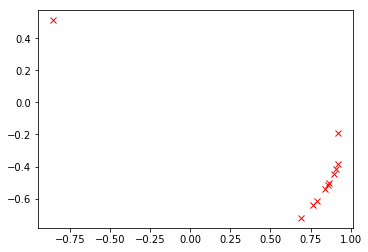

In [143]:
%%timeit

def phidiscinv(a, z):
    return (a.conjugate()*z - a)/(z-1)

cc = cgrid(32,6)

a = 2J
#cc = [ list(map(lambda z : phidiscinv(a, z), rr))  for rr in cc]
cc = [phidiscinv(a, Z) for Z in cc] # have to use masks for infty
#tt = list(itertools.chain.from_iterable(cc))

2.67 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
10.7 ms vs 2.67 

In [26]:
ZS

array([ 1.        +0.j        ,  0.66666667+0.33333333j,
        0.33333333+0.66666667j,  0.        +1.j        ,
       -0.33333333+0.66666667j, -0.66666667+0.33333333j,
       -1.        +0.j        , -0.66666667-0.33333333j,
       -0.33333333-0.66666667j, -0.        -1.j        ,
        0.33333333-0.66666667j,  0.66666667-0.33333333j,
        1.        +0.j        ])

# Bullshit I/O

In [252]:
def row2cplx(L):
    # this is a cheat to avoid problems with  #infinity in a file
    a, b = [float(x) for x in L.split()[:2]]
    return a + b*1J
    
z_i = [ row2cplx(row) for row in open("poly.txt").readlines()]

# set the interior point (conformal center) to the origin
z_i.append(complex(0))
    
grid = [ row2cplx(row) for row  in open("grid.txt").readlines() ]

# writes out the vertices z_i, letting infinity
# be written out as the origin
def writez(filename):
    with open(filename,"w") as fp:
        for p in z_i:
            if p != float("Infinity"):
                f.write(str(p.real) + " " + str(p.imag)+"\n")
            else:
                fp.write("0 0 #Infinity\n")
                
# writes out the grid with every pair
# of points grouped to allow for grid plotting
def writegrid(v,filename):
    with open(filename,"w") as f:
        for p in v:
            if p != float("Infinity"):
                f.write(str(p.real) + " " + str(p.imag)+"\n")
            else:
                f.write("0 0 #Infinity\n")
            if i%2 == 1:
                f.write("\n")

In [171]:

def half2plane(a,z):
    if cmath.isinf(z):
        return -(1j*a)**2
    
    #this is a dumb condition
    #this is basically saying z = a**2
    if abs(1 - z/a) < 1e-14:
        return cmath.inf
    
    return -( 1j*z / (1 - z/a) )**2

# the inverse of the (n+1)-th map
def plane2half(a,z):
    if cmath.isinf(z):
        return a
    
    if abs(z) < 1e-11:
        return 0

    if abs(z + (1j*a**2) < 1e-11:
        return cmath.inf
    
    sq = cmath.sqrt(-z)  
    if sq.imag*z.imag < 0:
        sq *= -1
    return sq*a/(1j*a + sq)

SyntaxError: invalid syntax (<ipython-input-171-5afeab6b8d74>, line 20)

In [ ]:
# the i-th map made from the basic map f_a
def f(a, z):
    # don't need cutoff going through list with a in it
    if z == a: return 0
    
    if cmath.isfinite(z):
        L = a.real * z / (abs(a)**2 + 1j*a.imag * z)
    else:
        if abs(a.imag) < 1e-14:
            return cmath.inf
        else:
            #the limit z -> infty in the expression above
            L = -1J * a.real / a.imag
        
    S = cmath.sqrt(L**2 - 1)
    #make S.imag L.imag same sign
    if S.imag*L.imag < 0:
        S *= -1
    return S


# the inverse of the i-th map
def f_inv(a, z):
    
    if cmath.isinf(z):
        return abs(a)**2 / (1j*a.imag)
    
    sq = cmath.sqrt(z**2 + 1)
    
    if sq.imag*z.imag < 0:
        sq *= -1
        
    if abs(a.real - sq*1j*a.imag) <= 1e-11:
        return cmath.inf
    
    return sq*abs(a)**2 / (a.real - sq*1j*a.imag)
